Assignment 2

In [6]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
salaries=pd.read_csv('Kaggle_Salary.csv',low_memory=False)[1:].set_index('index')

- We find that columns like "Unnamed: 0", "index" are irrelevant features to our task, so we just delete them.
- Columns with label 'othertext' are deleted because they lack of meaning.

In [8]:
salaries.head()

,Unnamed: 0,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,...,Q49_OTHER_TEXT,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT
index,,,,,,,,,,,,,,,,,,,,,
0.0,2,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
1.0,3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,...,-1,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1
2.0,5,731,Male,-1,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,-1,...,-1,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1
3.0,7,959,Male,-1,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,1,...,-1,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN,-1
4.0,8,1758,Male,-1,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,2,...,-1,NaN,NaN,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1


## data cleaning

In [9]:
# Remove empty columns
salaries=salaries.dropna(axis=1,how='all')

# Remove other_text columns
cols = [c for c in salaries.columns if c.lower()[-10:] != 'other_text']
salaries=salaries[cols]

# Remove Unnamed columns
salaries=salaries.drop(columns='Unnamed: 0')

# Remove _TEXT parts, the info that they contain is -1 or some numerical value which might not be useful.
salaries=salaries.drop(columns=['Q12_Part_1_TEXT','Q12_Part_2_TEXT','Q12_Part_3_TEXT','Q12_Part_4_TEXT',
                    'Q12_Part_5_TEXT','Q32_OTHER','Q47_Part_16'])

# Data preparation for exploratory analysis
salaries_analysis=salaries.copy()

# Take target column, salary column, out of the dataframe.
Salary=salaries['Q9'].astype(int)
salaries=salaries.drop(columns='Q9')#drop the target column

In [10]:
Y=Salary # Set as a target. 'training set and testing set'

In [11]:
# Replace missing values with zero
for item in salaries:
    null=salaries[item].isna().sum()
    if null<salaries.shape[0]*0.03:
        mode=salaries[item].mode() #return a series
        salaries[item]=salaries[item].fillna(mode[0])
        
# Replace all the NaN values with zero
salaries.fillna(0,inplace=True)

# Check and print the first 5 rows of each columns
print(salaries[:5][:])

      Time from Start to Finish (seconds)      Q1     Q2  \
index                                                      
0.0                                   434    Male  30-34   
1.0                                   718  Female  30-34   
2.0                                   731    Male  22-24   
3.0                                   959    Male  35-39   
4.0                                  1758    Male  18-21   
5.0                                   751    Male  30-34   

                             Q3                 Q4  \
index                                                
0.0                   Indonesia  Bachelor’s degree   
1.0    United States of America    Master’s degree   
2.0                       India    Master’s degree   
3.0                       Chile    Doctoral degree   
4.0                       India    Master’s degree   
5.0                     Hungary    Master’s degree   

                                                      Q5                 Q6  \
index  

- Here, we want to extract non-numerical contents in each question.
- The skipped labels are numerical labels.

In [12]:
la = preprocessing.LabelEncoder()
skip_label=set()
skip_label={'Time from Start to Finish (seconds)','Q34_Part_1','Q34_Part_2','Q34_Part_3','Q34_Part_4','Q34_Part_5',
                    'Q34_Part_6','Q35_Part_1','Q35_Part_2','Q35_Part_3','Q35_Part_4','Q35_Part_5','Q35_Part_6'}
classes=dict()
for items in salaries:
    if items in skip_label:
        pass
    else:
        salaries[items]=la.fit_transform(salaries[items].astype(str))#encode the data as strings.
        classes[items]=la.classes_
classes#check results

{'Q1': array(['Female', 'Male', 'Prefer not to say', 'Prefer to self-describe'],
       dtype=object),
 'Q2': array(['18-21', '22-24', '25-29', '30-34', '35-39', '40-44', '45-49',
        '50-54', '55-59', '60-69', '70-79', '80+'], dtype=object),
 'Q3': array(['Argentina', 'Australia', 'Austria', 'Bangladesh', 'Belarus',
        'Belgium', 'Brazil', 'Canada', 'Chile', 'China', 'Colombia',
        'Czech Republic', 'Denmark', 'Egypt', 'Finland', 'France',
        'Germany', 'Greece', 'Hong Kong (S.A.R.)', 'Hungary',
        'I do not wish to disclose my location', 'India', 'Indonesia',
        'Iran, Islamic Republic of...', 'Ireland', 'Israel', 'Italy',
        'Japan', 'Kenya', 'Malaysia', 'Mexico', 'Morocco', 'Netherlands',
        'New Zealand', 'Nigeria', 'Norway', 'Other', 'Pakistan', 'Peru',
        'Philippines', 'Poland', 'Portugal', 'Republic of Korea',
        'Romania', 'Russia', 'Singapore', 'South Africa', 'South Korea',
        'Spain', 'Sweden', 'Switzerland', 'Thailand'

In [13]:
#Final dataframe for model fitting
salaries['Time from Start to Finish (seconds)']=salaries['Time from Start to Finish (seconds)'].astype('int64')
salaries_model=salaries.copy()
salaries

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q10,...,Q49_Part_11,Q49_Part_12,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8
index,,,,,,,,,,,,,,,,,,,,,
0.0,434,1,3,22,0,2,11,9,10,1,...,0,0,0,0,0,0,0,0,0,0
1.0,718,0,3,56,3,1,7,7,0,0,...,0,0,0,1,0,0,0,0,0,0
2.0,731,1,1,21,3,8,4,7,0,0,...,0,0,0,1,0,0,1,0,0,0
3.0,959,1,4,8,1,7,11,0,2,1,...,0,0,1,0,0,0,0,1,0,0
4.0,1758,1,0,21,3,7,11,16,0,4,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15424.0,1800,1,3,32,3,1,17,3,2,2,...,0,0,0,0,0,0,0,0,0,0
15425.0,129,1,1,43,3,8,19,7,0,2,...,0,0,0,0,0,0,0,0,0,0
15426.0,348,1,3,53,1,1,14,0,10,2,...,0,0,0,0,0,0,0,0,0,0


# Step 2: Exploratory Data Analysis

- Columns with label 'OTHER_TEXT' have been removed

In [14]:
# the data frame
salaries_analysis

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,Q49_Part_11,Q49_Part_12,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8
index,,,,,,,,,,,,,,,,,,,,,
0.0,434,Male,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,Manufacturing/Fabrication,5-10,18668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0,718,Female,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,0-1,2726,...,NaN,NaN,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN
2.0,731,Male,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,I am a student,0-1,682,...,NaN,NaN,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN
3.0,959,Male,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,Academics/Education,10-15,11957,...,NaN,NaN,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN
4.0,1758,Male,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,Other,0-1,2696,...,NaN,NaN,NaN,NaN,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15424.0,1800,Male,30-34,Netherlands,Master’s degree,"Computer science (software engineering, etc.)",Software Engineer,Computers/Technology,10-15,90274,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15425.0,129,Male,22-24,Romania,Master’s degree,Mathematics or statistics,Student,I am a student,0-1,5508,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15426.0,348,Male,30-34,Turkey,Doctoral degree,"Computer science (software engineering, etc.)",Research Assistant,Academics/Education,5-10,15180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Visualization

In this part, 3 graphical figures would be presented that represent trends in the data.

**1. The most used programming language**
- Q17 indicates the most often used language in the data science.
- Based on Q17, the following plot had been made.
- A short conclusion can be made: Python, R and SQL are the three most used languages in data science around the world.

Text(0.5, 1.0, 'Programming Language popularities in Data Science')

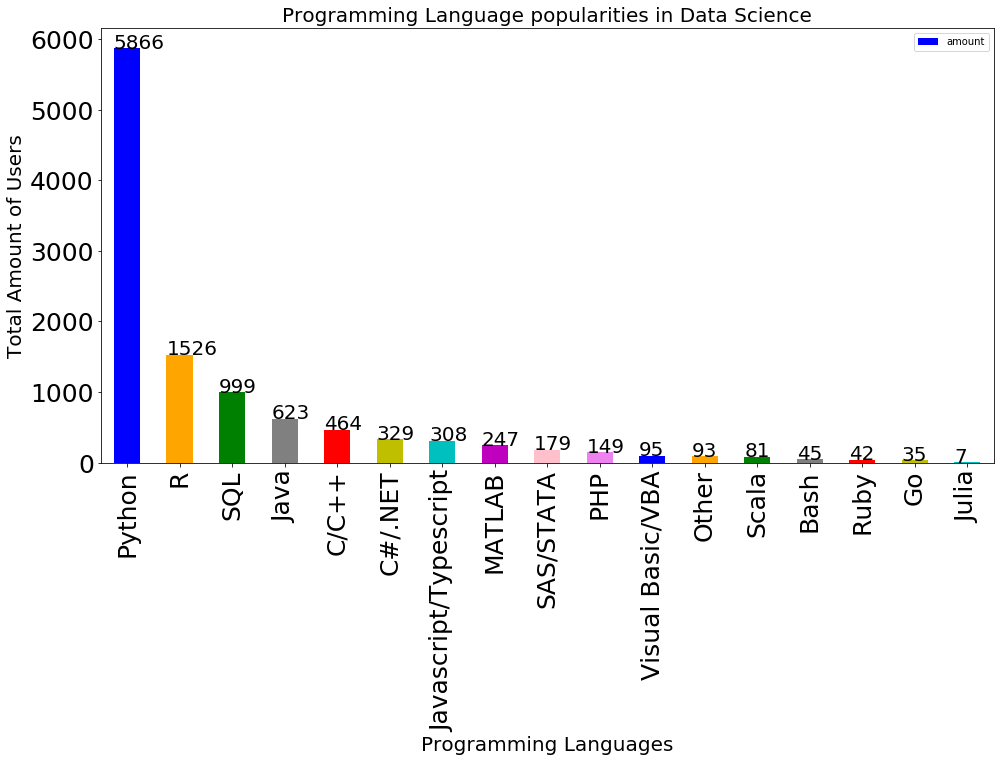

In [15]:
f=salaries_analysis['Q17'].value_counts().to_dict()

# Count the language numbers and the names of languages.
language=[]
counts=[]
for i,j in f.items():
    language.append(str(i))
    counts.append(int(j))

Plot=pd.DataFrame(columns=['pl','amount'])
Plot.pl=language
Plot.amount=counts

ax=Plot.plot.bar(x='pl', y='amount',color = ['b','orange','g','grey','r','y','c','m','pink','violet'],figsize=(16,8),fontsize=25)

for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()),fontsize=20)
    
plt.xlabel('Programming Languages',fontsize=20)
plt.ylabel('Total Amount of Users',fontsize=20)
plt.title(r'Programming Language popularities in Data Science',fontsize=20)

**2.The median salaries in different countries**
- By using Q9 and Q3, we can plot a figure that describe a relationship between yearly compensation and countries.
- Here, I did not use mean salaries to represent since the mean of salaries is not fair. There alway exists some persons who are special cases with extremely high salaries or extremely low salaries. That will make the mean values unfair

Text(0.5, 1.0, 'Top 10 Median Yearly compensation Countries')

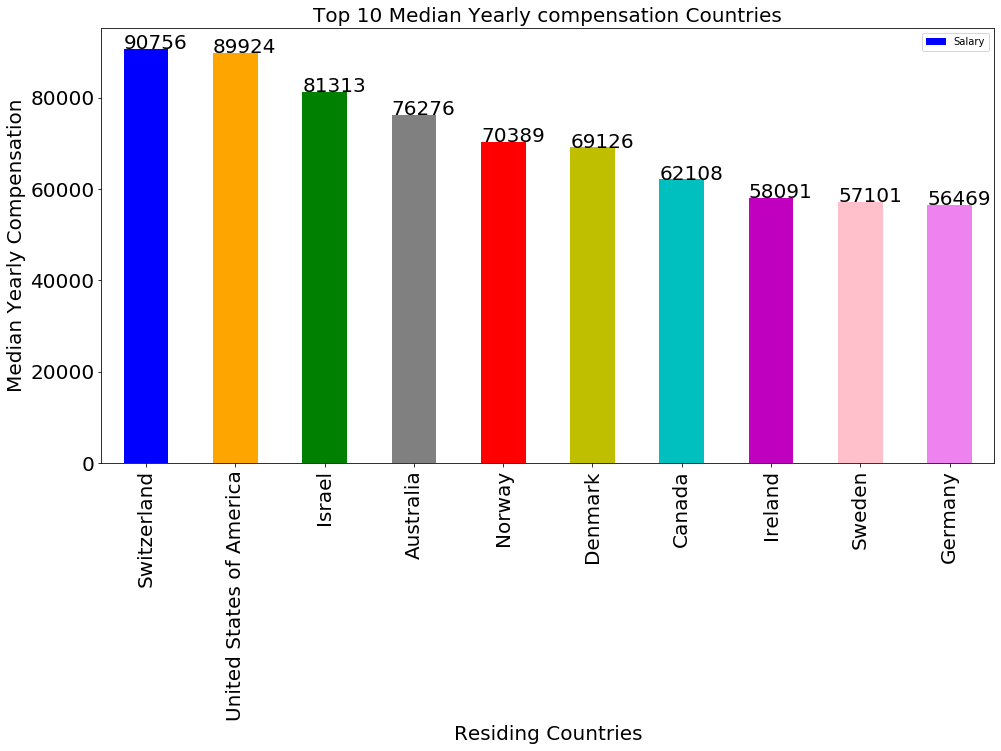

In [16]:
# Median salaries
salaries_analysis.Q9=salaries_analysis.Q9.astype(int)
grouped = salaries_analysis.groupby('Q3')
country_salary=grouped['Q9'].median()

# Plotting 
country=[]
salary=[]
for i,j in country_salary.iteritems():
    country.append(str(i))
    salary.append(int(j))

    
Country=pd.DataFrame(columns=['Country','Salary'])
Country.Country=country
Country.Salary=salary
Country=Country.sort_values(by='Salary',ascending=False)
ax=Country[:10].plot.bar(x='Country', y='Salary',color = ['b','orange','g','grey','r','y','c','m','pink','violet'],figsize=(16,8),fontsize=20)
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()),fontsize=20)
plt.xlabel('Residing Countries',fontsize=20)
plt.ylabel('Median Yearly Compensation',fontsize=20)
plt.title(r'Top 10 Median Yearly compensation Countries',fontsize=20)

**3. Different degrees will obtain different salaries**
- Q9 directly gives an answer to this question.
- By observeing the salaries that are from different degree levels, we can breifly say that generally, a person who has a higher degree level would get more money than those who has a lower degree.
- PhD usually has the highest yearly compensation.
- The highest yearly compensations in each degree level are almost same.

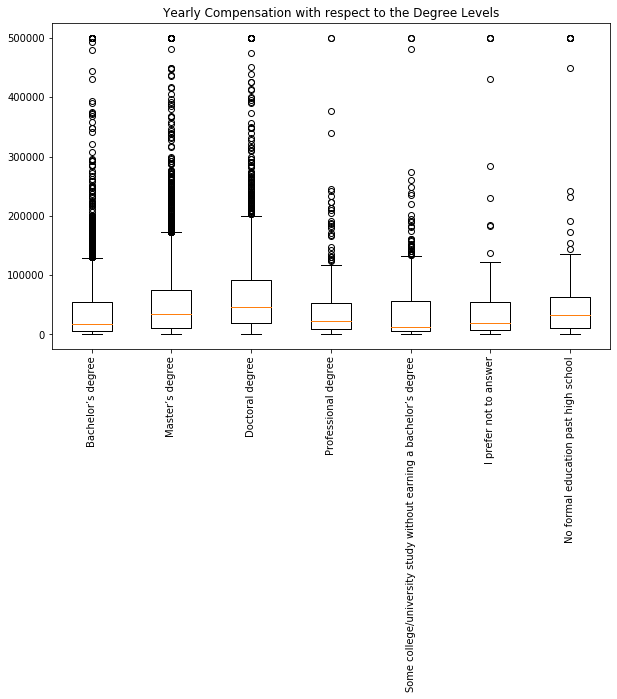

In [17]:
salaries_analysis.Q9=salaries_analysis.Q9.astype(int)

ed=dict()

for i,j in enumerate(salaries_analysis.Q4):
    if j not in ed:
        ed[str(j)]=[salaries_analysis.Q9[i]]
    else:
        ed[str(j)].append(salaries_analysis.Q9[i])

data = [ed['Bachelor’s degree'],ed['Master’s degree'],ed['Doctoral degree'],ed['Professional degree'],
        ed['Some college/university study without earning a bachelor’s degree'],ed['I prefer not to answer'],
       ed['No formal education past high school']]

fig, ax = plt.subplots(figsize=(10,6))
ax.set_title('Yearly Compensation with respect to the Degree Levels')
ax.boxplot(data,widths = 0.5,labels=['Bachelor’s degree','Master’s degree','Doctoral degree','Professional degree',
                                      'Some college/university study without earning a bachelor’s degree',
                                      'I prefer not to answer','No formal education past high school'])

plt.xticks(rotation=90)
plt.show()

In [18]:
# A quick view of a relationship between Q4 (degree levels) and Q9 (yearly compensation)
data = pd.concat([salaries_analysis.Q9,salaries_analysis.Q4],axis = 1).set_index('Q4')
data

,Q9
Q4,
Bachelor’s degree,18668
Master’s degree,2726
Master’s degree,682
Doctoral degree,11957
Master’s degree,2696
...,...
Master’s degree,90274
Master’s degree,5508
Doctoral degree,15180


**Visualize the order of feature importance**
- Correlation plot had been used here.
- In this part, we want to inspect which features or which of the original attributes in the data are most related to a survey respondent’s yearly compensation.

In [19]:
# The correlation matrix
salaries.corr()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q10,...,Q49_Part_11,Q49_Part_12,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8
Time from Start to Finish (seconds),1.000000,-0.004463,0.000337,-0.014797,0.007910,0.006171,-0.004346,0.002803,-0.017013,0.020556,...,-0.001337,0.004750,-0.001380,-0.013924,-0.000433,-0.013885,-0.027075,-0.010462,-0.006990,-0.020766
Q1,-0.004463,1.000000,0.069411,-0.069262,-0.011180,-0.053553,0.003394,0.002820,0.068701,0.021187,...,-0.003355,0.000326,0.037764,0.033958,0.005713,0.012585,0.029680,-0.006877,-0.002401,-0.023410
Q2,0.000337,0.069411,1.000000,0.112969,0.079423,0.090619,-0.250534,-0.027135,0.311633,0.086419,...,0.029614,0.047608,-0.003507,0.038894,-0.018656,-0.010542,0.027590,-0.010403,0.084342,0.043445
Q3,-0.014797,-0.069262,0.112969,1.000000,0.010195,0.114892,-0.067063,0.054345,0.013384,0.042902,...,-0.001808,0.026038,-0.017978,0.051073,-0.020354,-0.005881,0.031480,0.003217,0.041181,0.039401
Q4,0.007910,-0.011180,0.079423,0.010195,1.000000,0.005619,-0.067402,0.031083,0.027121,0.025900,...,-0.001039,0.000934,0.008655,-0.007372,-0.005622,0.000701,-0.009661,0.000932,0.008838,0.000429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q50_Part_4,-0.013885,0.012585,-0.010542,-0.005881,0.000701,-0.004365,0.003506,-0.020445,-0.005278,0.032549,...,-0.036591,-0.017993,0.085791,0.153960,0.109950,1.000000,0.231021,0.023288,-0.120479,-0.012321
Q50_Part_5,-0.027075,0.029680,0.027590,0.031480,-0.009661,0.033539,-0.043024,0.002874,0.018952,0.084875,...,-0.015853,-0.018361,0.103548,0.299544,0.102035,0.231021,1.000000,0.037076,-0.170759,-0.014016
Q50_Part_6,-0.010462,-0.006877,-0.010403,0.003217,0.000932,-0.011212,0.004345,0.014201,-0.004324,-0.016082,...,0.157277,-0.000716,0.006316,-0.005644,0.036651,0.023288,0.037076,1.000000,-0.082678,-0.029198
Q50_Part_7,-0.006990,-0.002401,0.084342,0.041181,0.008838,0.027654,-0.037624,0.024841,0.021744,0.006702,...,0.235778,0.051943,-0.095899,-0.254882,-0.139339,-0.120479,-0.170759,-0.082678,1.000000,-0.058566


In [20]:
from matplotlib import cm as cm

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


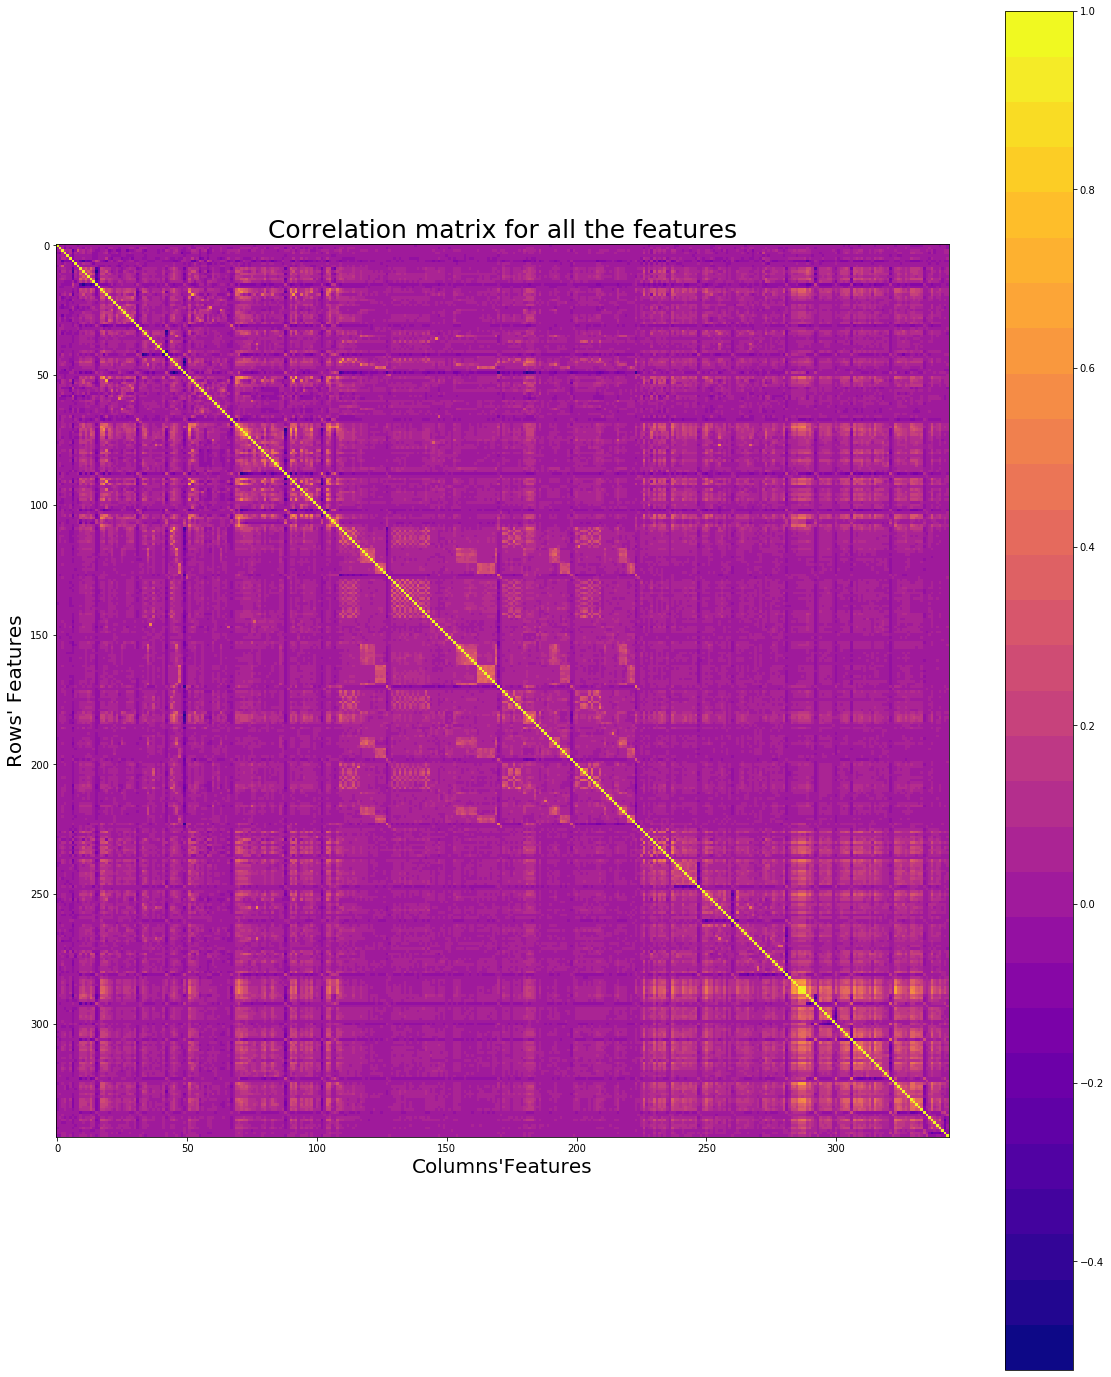

In [21]:
fig = plt.figure(figsize=(20,25))
plt.xlabel("Columns'Features",fontsize=20)
plt.ylabel("Rows' Features",fontsize=20)
plt.title(r'Correlation matrix for all the features',fontsize=25)
ax1 = fig.add_subplot(111)
cmap = cm.get_cmap('plasma', 30)
cax = ax1.imshow(salaries.corr(), interpolation="nearest", cmap=cmap)
fig.colorbar(cax, ticks=np.linspace(-1,1,11))

**Cannot learn anything from this plot**
- The matrix is too big. Even we delete features, it is still too big for us to observe the details. 
- We cannot directly say that some feature has a very close relation with Q9(yearly compensation).
- Hence, I print rank the corr_values and print them out.

In [22]:
salaries['Q9']=Y
Q9 = salaries.corr()
Q9['Q9'].sort_values(ascending=False)

Q9            1.000000
Q2            0.422698
Q3            0.267941
Q15_Part_2    0.208550
Q27_Part_1    0.203035
                ...   
Q13_Part_7   -0.070744
Q16_Part_8   -0.072973
Q11_Part_6   -0.108822
Q15_Part_6   -0.140391
Q6           -0.215452
Name: Q9, Length: 345, dtype: float64

In [23]:
salaries = salaries.drop(columns='Q9')

- We can see that Q2 has the highest correlation score and Q3 following.
- Q2 is the age of the person
- Q3 is the employing country
- Q15_part2 (worked in Amazon) and Q27_part1 (used AWS elastic compute cloud) might be plus for the yearly compensation.

# Feature Selection

**Explain how feature engineering is a useful tool in machine learning.**
- Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 
- Feature engineering will increase the predictive power and reduce the runtime of machine learning algorithms by choosing correct key features that would facilitate machine learning processes. 
- The quality and quantity of the features will have great influence on whether the model is good or not.

**Manual Removed features:**
- Features with label 'OTHER_TEXT' have been removed. -1 majors in these columns. -1 does not make too much sense. (I guess -1 infers Nan.)
- Unnamed: 0 columns have also been removed: they are meaningless for me because they lack of information.
- NULL values columns, Q38_Part_19 and Q38_Part_20 columns, had been removed.

**Using L1-Lasso Regularizer and Principal Component Analysis (PCA) to do feature selection**
- PCA: PCA tries to find the directions of most variation in the dataset. Usually, it can be used to select important variables and reduce the dimensions of the original data. Hence, it enables us to pick the most important variables in the original data space.

- L1-Lasso regularizer: this method returns a resulting coefficients of the features, these values of coefficients could be positive or negative and they can indicate an insight to the relationships between a feature and yearly compensation. Hence, after filtering some values, by using a threshold value, features who are important to the yearly compensation would be kept and the others would be removed.


- PCA methods select the most n important features from the original dataset. where n is set to 200.
- PCA reduce the dimensions of the dataset to 200.

In [24]:
X_Train_All,X_Test_All,Y_Train,Y_test=train_test_split(salaries_model,Y,test_size=0.2,shuffle=True)

In [25]:
def feature_elimination(X_Train, X_Test, Y_Train, method='pca', para=200):
    if method not in ['pca','lassocv']:
        print("We don't have this kind of method for normalization. Please choose from ['variance','pca','mul_info']")
        return X_Train, X_Test
    else:
        if method=='lassocv':
            clf = LassoCV(cv=5)
            sfm = SelectFromModel(clf, threshold=0.25)
            sfm.fit(X_Train, Y_Train)
            X_Train = sfm.transform(X_Train)
            X_Test = sfm.transform(X_Test)
            return pd.DataFrame(X_Train), pd.DataFrame(X_Test)
        else:
            sel = PCA(n_components=para).fit(X_Train)
            X_Train = sel.transform(X_Train)
            X_Test = sel.transform(X_Test)
            return pd.DataFrame(X_Train), pd.DataFrame(X_Test)

In [26]:
PX_Train, PX_Test = feature_elimination(X_Train_All,X_Test_All,Y_Train,method='pca', para=200)

In [27]:
PX_Train

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-12141.828493,1.962841,-33.791348,22.724564,-32.696520,24.801648,19.582100,-4.430098,-10.843271,11.349465,...,-0.120039,0.227825,-0.449498,0.538837,0.438896,-0.001128,0.046054,-0.117790,-0.224013,0.001100
1,-12432.829958,16.300777,24.407445,-24.994237,-17.295027,-28.502881,3.346771,-15.341234,-7.774948,4.912835,...,0.095445,-0.218681,-0.115348,-0.094205,0.231339,0.118384,0.291660,-0.269154,-0.082794,0.038711
2,152473.170812,-43.588698,10.971368,-21.538286,-5.245275,8.946717,-5.493808,-3.284988,-3.083570,-0.869469,...,0.038084,0.005724,-0.032419,-0.000699,0.015372,-0.012901,0.011691,0.004634,-0.001380,0.063931
3,-11613.829817,16.991329,38.143974,4.473163,9.266650,6.734874,-7.858882,-21.172444,4.227065,25.371716,...,-0.193650,-0.001838,-0.153719,0.002405,-0.381739,0.044564,0.037745,-0.002787,0.164506,-0.085198
4,-12765.829289,-42.213811,6.592368,-18.729798,-5.368382,-6.580193,-0.694778,-1.081399,-2.557636,-1.510732,...,0.014942,-0.370165,-0.222354,-0.055141,-0.265122,0.065074,-0.020271,0.313821,0.332593,0.004965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12338,-10500.828935,10.599315,-0.047757,-5.044972,2.292138,24.946286,5.105030,-2.924151,4.755713,-0.281243,...,0.264548,-0.354928,-0.567071,0.008390,0.189377,-0.203846,-0.006038,0.377735,0.265200,-0.036643
12339,-12993.829321,-41.420684,6.252703,-18.012014,-5.151718,-10.515227,-0.334842,-0.724998,-2.308111,-0.958208,...,-0.156078,0.075147,0.179925,0.090221,-0.233136,-0.330444,0.089656,-0.184047,0.327839,0.609861
12340,-12659.828879,23.148966,-30.501418,-14.238967,34.663120,-14.264708,14.238991,-8.275075,-3.081925,-12.538932,...,-0.226340,0.305980,-0.339509,0.606410,0.074441,-0.229240,-0.002723,0.090880,-0.113740,0.092374
12341,151439.170886,-43.803237,11.674683,-22.299579,-5.343695,17.733254,-6.846744,-3.956828,-3.415547,-0.879147,...,0.012130,0.008608,-0.015381,0.003767,0.002112,0.005854,-0.007687,0.001956,0.000432,-0.009269


In [28]:
type(PX_Train)

pandas.core.frame.DataFrame

In [32]:
Y_Train[tran_index]

NameError: name 'tran_index' is not defined

# Model Implementation

- A class had been defined by HANWEN that is used here.
- Reference:https://github.com/hanwen0529/Introduction-to-Data-Science-and-Analytics/blob/master/Salary_Prediction/salary_prediction.ipynb
- I will use LinearRegrassion and GradientBoostingTree on the dataset which is processed by PCA.

In [23]:
from collections import OrderedDict

from sklearn.linear_model import LinearRegression as lr
from sklearn.linear_model import Lasso as lasso
from sklearn.linear_model import ElasticNet as elsnet
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import GradientBoostingRegressor as gbr

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error
from sklearn.metrics import roc_auc_score, roc_curve, auc,confusion_matrix,accuracy_score

def bias(y_predict,y):
    y_predict = np.array(y_predict)
    y = np.array(y)
    avg = np.average(y_predict)
    return np.sqrt(np.average(np.power((avg-y),2)))
def variance(y_predict):
    y_predict = np.array(y_predict)
    return np.sqrt(np.var(y_predict))

def two_score(y_true,y_pred):    
    mean_squared_error(y_true,y_pred) #set score here and not below if using MSE in GridCV
    score = r2_score(y_true,y_pred)
    return score

def run_kfold(model,X,y,folds=10):
    kf = KFold(n_splits=folds)
    kf.get_n_splits(X)
    score_keep = []
    trade_keep = []
    fold = 0
    print("The result with {}-fold cross-validation on training set".format(folds))

    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

        train_r2 = r2_score(y_train, y_train_predict)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_predict))
        train_mae = mean_absolute_error(y_test, y_test_predict)
        
        test_r2 = r2_score(y_test, y_test_predict)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_predict))
        test_mae = mean_absolute_error(y_test, y_test_predict)
        # print("Fold {} R2 training score: {}, testing score: {}".format(fold,train_r2,test_r2))
        # print("RMSE training score: {}, testing score: {}".format(train_rmse,test_rmse))
        train_bia = bias(y_train_predict,y_train)
        train_var = variance(y_train_predict)
        train_total = train_bia + train_var
        
        test_bia = bias(y_test_predict,y_train)
        test_var = variance(y_test_predict)
        test_total = test_bia + test_var

        score_keep.append((train_r2, test_r2,train_rmse, test_rmse,train_mae,test_mae))
        trade_keep.append((train_bia,test_bia,train_var,test_var,train_total,test_total))
    score_df = pd.DataFrame(score_keep, columns=["train_R2","test_R2","train_RMSE","test_RMSE","train_MAE","test_MAE"])
    trade_df = pd.DataFrame(trade_keep, columns=["train_bia","test_bia","train_var","test_var","train_total","test_total"])
    print(score_df.describe()[["test_R2","test_RMSE","test_MAE"]][1:4])
    return clf, score_df, trade_df

class Regressor(object):
    def __init__(self,train_data,train_targets):
        super().__init__()
        self.train_data = train_data
        self.train_targets = train_targets
        rfrhyperpara = {'n_estimators': list(range(85,120,5)),'max_depth': list(range(45,60,3)),'min_samples_leaf': [1, 2, 3]}
        gbrhyperpara = {'n_estimators': list(range(90,120,5)),'max_depth': list(range(4,15,3)),'min_samples_leaf': [1, 2]}
        self.models=OrderedDict([('LinearRegression',[lr(),None]),\
                            ('Lasso',[lasso(alpha=9.0,max_iter=2000,random_state=20),dict(alpha=np.arange(5,15,0.5))]),\
                            ('ElasticNet',[elsnet(l1_ratio=0.8),dict(l1_ratio=np.linspace(0,1,10))]),\
                            ('RandomForest',[rfr(n_estimators = 105, max_depth=40, min_samples_leaf=2),rfrhyperpara]),\
                            ('GradientBoosting',[gbr(),gbrhyperpara])])
        #1.1 and 2.70 # ElasticNet(alpha=1.0, l1_ratio=0.5）
    def train_model(self,model_name,scorer="R2",ifhyper_tune=False,hyper_paras="",folder=10):
        self.model_name = model_name
        model = self.models[model_name][0]
        if ifhyper_tune:
            if not hyper_paras:
                hyper_paras = self.models[model_name][1]
            # Grid search method for hyper-parameter tuning in which we use 5-fold cross validation
            if hyper_paras:
                if scorer=='R2':
                    acc_scorer = make_scorer(r2_score)
                elif scorer == 'RMSE':
                    acc_scorer = make_scorer(mean_squared_error)
                else:
                    acc_scorer = make_scorer(two_score, greater_is_better=True)
                grid = GridSearchCV(model, hyper_paras, cv=5, scoring=acc_scorer, n_jobs=-1) 

                grid.fit(self.train_data, self.train_targets)
                print('The best score of model {} through {}-cross validation is {}, with the best hyper-parameter {}\n'\
                    .format(model_name, 5, grid.best_score_, grid.best_params_))

                # Best model
                best_model = grid.best_estimator_
            else:
                best_model = model.fit(self.train_data,self.train_targets)
            train_pred = best_model.predict(self.train_data)
            R2 = r2_score(self.train_targets,train_pred)
            print('Through Hypertuning on {}, we get the best model and the results below:'.format(model_name))
            print('The R2 score is {}'.format(R2))
            RMSE = np.sqrt(mean_squared_error(self.train_targets,train_pred))
            print('The RMSE score is {}'.format(RMSE))
            MAE = mean_absolute_error(self.train_targets,train_pred)
            print('The MAE score is {}'.format(MAE))
            score_df = pd.DataFrame([(R2,RMSE,MAE)], columns=["R2", "RMSE","MAE"])
        else:
            best_model, score_df, trade_df = run_kfold(model,self.train_data,self.train_targets,folder)
        
        self.best_model = best_model
        if ifhyper_tune:
            return best_model, score_df
        else:
            return best_model, score_df, trade_df

    def test_model(self,test_data,test_targets,new_best=None):
        if new_best is not None:
            test_pred = new_best.predict(test_data)
        else:
            test_pred = self.best_model.predict(test_data)
            print("Result of Model {} is list below:".format(self.model_name))
        R2 = r2_score(test_targets, test_pred)
        RMSE = np.sqrt(mean_squared_error(test_targets,test_pred))
        MAE = mean_absolute_error(test_targets,test_pred)
        BIAS = bias(test_pred,test_targets)
        VAR = variance(test_pred)
        TOTAL = BIAS + VAR
        # test accuracy
        print('R2 score is {}'.format(R2))
        print('RMSE socre is {}'.format(RMSE))
        print('MeanAbsoluteError is {}'.format(MAE))
        # print('Bias score is {}'.format(BIAS))
        # print('Variance score is {}'.format(VAR))
        # print('Bias+Variance score is {}'.format(TOTAL))
        return R2, RMSE, MAE, BIAS, VAR, TOTAL

### Discussion about algorithms
**Linear Regression**
- `pros` Linear regression is an extremely simple method. It is very easy and intuitive to use and understand.
- `cons` linear regression only models relationships between dependent and independent variables that are linear.

**Gradient Boosting Tree**
- `pros` High-performing. GBT often provides the highest predictive accuracy among these algorithms.
- `cons` GBT continues improving to minimize all errors which will cause overfitting. Not easy to understand predictions

**Elastic Net**
- `pros` It uses l1-penalty to help generating a sparse model and l2-part to overcome a strict selection
- `cons` Elastic Net is still based on the Linear Regression, so that it assume the relationships are linear which might not be accurate in real life.

**Random Forest**
- `pros` One of the most accurate decision models; Works well on large datasets. 
- `cons` Overfitting in case of noisy data; Hyperparamters needs good tuning for high accuracy.

In [24]:
PcaFeatureReg = Regressor(PX_Train,Y_Train)

In [77]:
print('Result from LinearRegression:')
plr_model, plr_score, plr_trade = PcaFeatureReg.train_model('LinearRegression')

print('\nResult from ElasticNet:')
pelc_model, pelc_score, pelc_trade = PcaFeatureReg.train_model('ElasticNet')

print('\nResult from RandomForest:')
prfr_model, prfr_score, prfr_trade = PcaFeatureReg.train_model('RandomForest')

print('\nResult from GradientBoosting:')
pgdb_model, pgdb_score, pgdb_trade = PcaFeatureReg.train_model('GradientBoosting')

print('\nResult from Lasso:')
plasso_model, plasso_score, plasso_trade = PcaFeatureReg.train_model('Lasso')

Result from LinearRegression:
The result with 10-fold cross-validation on training set
       test_R2     test_RMSE      test_MAE
mean  0.331377  50650.355237  31404.233612
std   0.026589   4404.314203   1145.181832
min   0.297861  45075.532881  29646.512781

Result from ElasticNet:
The result with 10-fold cross-validation on training set
       test_R2     test_RMSE      test_MAE
mean  0.325931  50869.300477  31182.186257
std   0.026128   4577.880447   1155.338606
min   0.294948  45081.606445  29268.566824

Result from RandomForest:
The result with 10-fold cross-validation on training set
       test_R2     test_RMSE      test_MAE
mean  0.293382  52082.917807  32159.859778
std   0.031515   4739.136154   1413.233333
min   0.251529  46168.916660  29704.530073

Result from GradientBoosting:
The result with 10-fold cross-validation on training set
       test_R2     test_RMSE      test_MAE
mean  0.314193  51310.240812  30931.889927
std   0.034539   4753.409722   1568.773041
min   0.253657

**What is average and variance of accuracy for folds? What is average and variance of accuracy for folds?**
- R2 value and RMSE score are almost the same across different algorithms. Lasso has the best R2 score and Lasso also has the best RMSE score. The MAE score of GradientBoosting is the lowest but it has high variance.


**Which model performed best? Give the reason based on bias-variance trade-off**
Bias-variance tradeoff：
- Bias are the simplifying assumptions made by a model to make the target function easier to learn. High bias can cause an algorithm to miss the relevant relations between features and target outputs (underfitting).
- Variance is the amount that the estimate of the target function will change if different training data was used. high variance can cause overfitting.
Lasso regression represents the highest r2 values in these method. It means that the data has high bias. It can also be observed that when we increase the number of iterations in gradient boosting, r2 square value also improves.

In [25]:
LX_Train, LX_Test = feature_elimination(X_Train_All,X_Test_All,Y_Train,'lassocv')

In [26]:
LeFeatureReg = Regressor(LX_Train,Y_Train)

# Model Tuning

In this part, we use GridSearch Cross-Validation to tune the hyperparameters.
- GridSearchCV will give the best hyperparameters based on the average R2 score.

In [90]:
# Linear Regression hyperparameters tuning.
lr_bestmodel, lr_bestscore = LeFeatureReg.train_model('LinearRegression',ifhyper_tune=True)

Through Hypertuning on LinearRegression, we get the best model and the results below:
The R2 score is 0.25737957434449554
The RMSE score is 53502.61599671789
The MAE score is 33216.737304404254


In [91]:
# Random forest hyperparameter tuning.
rfr_bestmodel, rfr_bestscore = LeFeatureReg.train_model('RandomForest',ifhyper_tune=True)

The best score of model RandomForest through 5-cross validation is 0.39988216913156427, with the best hyper-parameter {'max_depth': 57, 'min_samples_leaf': 3, 'n_estimators': 110}

Through Hypertuning on RandomForest, we get the best model and the results below:
The R2 score is 0.7107345393866529
The RMSE score is 33391.80244336683
The MAE score is 16598.46155107019


#### One interesting thing that I would like to point it out is Random Forest could reach extremely high accuracy once its hyperparamters gets good tuning:
- Before the hyperparameters tuning, R2 score is 0.29.
- After the hyperparameters tuning, R2 score is up to 0.71

In [92]:
# ElasticNet hyperparameters tuning.
elc_bestmodel, elc_bestscore = LeFeatureReg.train_model('ElasticNet',ifhyper_tune=True)

The best score of model ElasticNet through 5-cross validation is 0.2556321664699412, with the best hyper-parameter {'l1_ratio': 1.0}

Through Hypertuning on ElasticNet, we get the best model and the results below:
The R2 score is 0.25737957425896507
The RMSE score is 53502.61599979894
The MAE score is 33216.71636771566


In [93]:
# Gradient Boosting hyperparameters tuning.
gdb_bestmodel, gdb_bestscore = LeFeatureReg.train_model('GradientBoosting',ifhyper_tune=True)

The best score of model GradientBoosting through 5-cross validation is 0.4345752574505289, with the best hyper-parameter {'max_depth': 4, 'min_samples_leaf': 1, 'n_estimators': 115}

Through Hypertuning on GradientBoosting, we get the best model and the results below:
The R2 score is 0.5245206355735373
The RMSE score is 42811.20074789498
The MAE score is 23413.412973005165


**Choosing an optimal model**
- The best model has been obtained based on the hyperparameter tuning. We also obtained the performance for each of model. Based on their R2, MAE and RMSE scores, we can choose the best model is Random forest as the model that is the best model based on the training dataset
- Gradient boosting also gets a relevant high accuracy, R2 ~ 0.52. So that I would like to implement this two methods in the test parts.

# Test and Discussion

Using two optimal models to do a test
- 1. Random forest

In [103]:
print("For model Random forest, the training results of best model is listed below:")
rfr_besttrn_result = LeFeatureReg.test_model(LX_Train,Y_Train,rfr_bestmodel)
print("The testing results of best model is listed below:")
rfr_besttst_result = LeFeatureReg.test_model(LX_Test,Y_test,rfr_bestmodel)

For model Random forest, the training results of best model is listed below:
R2 score is 0.7107345393866529
RMSE socre is 33391.80244336683
MeanAbsoluteError is 16598.46155107019
The testing results of best model is listed below:
R2 score is 0.3964882188728679
RMSE socre is 48802.36810583979
MeanAbsoluteError is 26436.611518834758


In [106]:
print(rfr_besttrn_result,'\n',rfr_besttst_result)

(0.7107345393866529, 33391.80244336683, 16598.46155107019, 62090.00952007593, 44557.0999750836, 106647.10949515953) 
 (0.3964882188728679, 48802.36810583979, 26436.611518834758, 62839.62512219731, 41611.575403695606, 104451.20052589291)


- 2. Gradient Boosting

In [101]:
print("For model Gradient Boosting, the training results of best model is listed below:")
gdb_besttrn_result = LeFeatureReg.test_model(LX_Train,Y_Train,gdb_bestmodel)
print("The testing results of best model is listed below:")
gdb_besttst_result = LeFeatureReg.test_model(LX_Test,Y_test,gdb_bestmodel)

For model Gradient Boosting, the training results of best model is listed below:
R2 score is 0.5245206355735373
RMSE socre is 42811.20074789498
MeanAbsoluteError is 23413.412973005165
The testing results of best model is listed below:
R2 score is 0.4226500103411581
RMSE socre is 47732.87590619379
MeanAbsoluteError is 25270.65458318574


In [105]:
print(gdb_besttrn_result,'\n',gdb_besttst_result)

(0.5245206355735373, 42811.20074789498, 23413.412973005165, 62085.698583320554, 40834.14043159646, 102919.83901491702) 
 (0.4226500103411581, 47732.87590619379, 25270.65458318574, 62824.2214049275, 40227.610787889826, 103051.83219281732)


**How does your model perform on the test set vs. the training set? The overall fit of the model, how to increase the accuracy (test, training)? Is it overfitting or underfitting? Why?**
For both Random forest model and Gradient Boosting model, the training scores are higher than the testing scores. That is the performance on the training set is better than the performance on the testing set.

For the Random Forest model:
- Testing_Bias (62839) > Training_Bias (62090)
- Testing_Var (41611) < Training_Var (44557)

For the Gradient Boosting model:
- Testing_Bias (62824) > Training_Bias (62085)
- Testing_Var (40227) < Training_Var (40834)

An underfitting has been made for both of these two models.
Underfitting occurs when the machine learning model cannot capture the underlying trend of the data. Intuitively, underfitting occurs when the model does not fit the data well enough. Specifically,underfitting occurs if the model or algorithm shows low variance but high bias. 

Since the dataset that I used is processed by PCA, the deminsons of the dataset has been reduced from 350+ down to 200. Too much of the information might be removed during the PCA process. To improve the models, we can give more details to the model. Thereby, the underfitting might be improved.

In Random Forest model and Gradient Boosting Tree model, the depth of trees also plays a important role. We can increase the depth of trees to increase the complexity of the model so that improve the underfitting.